<a href="https://colab.research.google.com/github/vinaykumar2491/Project_MachineLearning/blob/master/imflash217_fastai_5_sgd_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## SGD MNIST:

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.basics import *

In [0]:
### Get the pickled MNIST dataset from http://deeplearning.net/data/mnist/mnist.pkl.gz
### We are going to treat it as a standard flat dataset with fully connected layers, rather tha using a CNN

In [5]:
!wget http://deeplearning.net/data/mnist/mnist.pkl.gz

--2019-10-13 15:15:11--  http://deeplearning.net/data/mnist/mnist.pkl.gz
Resolving deeplearning.net (deeplearning.net)... 132.204.26.28
Connecting to deeplearning.net (deeplearning.net)|132.204.26.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16168813 (15M) [application/x-gzip]
Saving to: ‘mnist.pkl.gz’

mnist.pkl.gz        100%[===================>]  15.42M  17.4MB/s    in 0.9s    

2019-10-13 15:15:12 (17.4 MB/s) - ‘mnist.pkl.gz’ saved [16168813/16168813]



In [6]:
ls

mnist.pkl.gz  sample_data/


In [7]:
Config.data_path()

PosixPath('/root/.fastai/data')

In [0]:
!mkdir mnist

In [11]:
ls

mnist/  mnist.pkl.gz  sample_data/


In [0]:
!mv mnist.pkl.gz mnist/mnist.pkl.gz

In [13]:
ls

mnist/  sample_data/


In [14]:
ls mnist 

mnist.pkl.gz


In [0]:
!cp -r mnist /root/.fastai/data/

In [17]:
ls /root/.fastai/data/

mnist.pkl.gz


In [18]:
Config.data_path()

PosixPath('/root/.fastai/data')

In [0]:
path = Config.data_path()

In [21]:
path.ls()

[PosixPath('/root/.fastai/data/mnist.pkl.gz')]

In [24]:
with gzip.open(path/"mnist.pkl.gz", "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

x_train.shape[0] == y_train.shape[0]

True

In [25]:
x_train.shape

(50000, 784)

In [27]:
y_train.shape

(50000,)

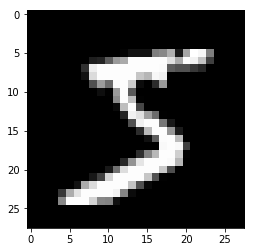

In [29]:
plt.imshow(x_train[0].reshape((28, 28)), cmap="gray")

In [30]:
type(x_train[0])

numpy.ndarray

In [31]:
### converting the numpy arrays to torch tensor
x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))
n, c = x_train.shape
n, c

(50000, 784)

In [32]:
x_train.shape, y_train.min(), y_train.max()

(torch.Size([50000, 784]), tensor(0), tensor(9))

In [0]:
bs = 32
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds=train_ds, valid_ds=valid_ds, bs=bs)

In [35]:
data

DataBunch;

Train: <torch.utils.data.dataset.TensorDataset object at 0x7fc27690e908>;

Valid: <torch.utils.data.dataset.TensorDataset object at 0x7fc27690e940>;

Test: None

In [36]:
data.train_dl

DeviceDataLoader(dl=<torch.utils.data.dataloader.DataLoader object at 0x7fc27690ea90>, device=device(type='cuda'), tfms=[], collate_fn=<function data_collate at 0x7fc27beaa9d8>)

In [37]:
x, y = next(iter(data.train_dl))
x.shape, y.shape

(torch.Size([32, 784]), torch.Size([32]))

In [0]:
### creating the model

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=int(x_train.shape[1]), out_features=(int(y_train.max())+1), bias=True)
    def forward(self, xb):
        return self.linear_layer(xb)


In [0]:
model = Mnist_Logistic()

In [46]:
model

Mnist_Logistic(
  (linear_layer): Linear(in_features=784, out_features=10, bias=True)
)

In [55]:
model.cuda()

Mnist_Logistic(
  (linear_layer): Linear(in_features=784, out_features=10, bias=True)
)

In [56]:
model

Mnist_Logistic(
  (linear_layer): Linear(in_features=784, out_features=10, bias=True)
)

In [0]:
model = model.cuda()

In [60]:
x.shape

torch.Size([32, 784])

In [61]:
x.device

device(type='cuda', index=0)

In [62]:
model(x).shape

torch.Size([32, 10])

In [65]:
[p.shape for p in model.parameters()]

[torch.Size([10, 784]), torch.Size([10])]

In [0]:
lr = 2e-2

In [0]:
loss_func = nn.CrossEntropyLoss()

In [0]:
def update(x, y, lr):
    wd = 1e-5
    y_hat = model(x)

    ## weight decay steps
    ## calculating the L2 weight decay
    w2 = 0.
    for p in model.parameters():
        w2 += (p**2).sum()
    
    ## add the weight decay to regular loss
    loss = loss_func(y_hat, y) + wd*w2
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr*p.grad)
            p.grad.zero_()
    return loss.item()

In [0]:
losses = [update(x, y, lr) for x, y in data.train_dl]

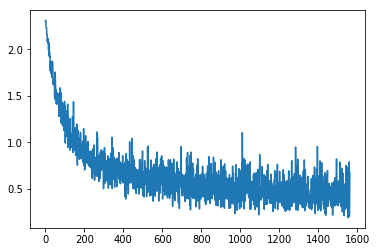

In [71]:
plt.plot(losses)

In [0]:
### creating the 2 layer Neural Network
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(in_features=int(x_train.shape[1]), out_features=50, bias=True)
        self.lin2 = nn.Linear(in_features=50, out_features=int(y_train.max()+1), bias=True)
    def forward(self, xb):
        x1 = self.lin1(xb)
        x2 = F.relu(x1)
        return self.lin2(x2)


In [0]:
model = Mnist_NN().cuda()

In [74]:
model

Mnist_NN(
  (lin1): Linear(in_features=784, out_features=50, bias=True)
  (lin2): Linear(in_features=50, out_features=10, bias=True)
)

In [0]:
losses = [update(x, y, lr) for x, y in data.train_dl]

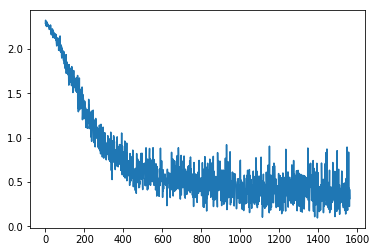

In [76]:
plt.plot(losses)

In [0]:
def update(x, y, lr):
    opt = optim.Adam(params=model.parameters(), lr=lr)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()


In [0]:
losses = [update(x,y,lr) for x,y in data.train_dl]

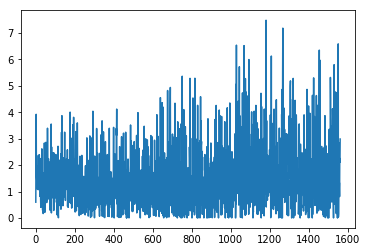

In [79]:
plt.plot(losses)

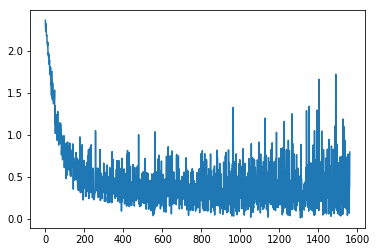

In [81]:
model = Mnist_NN().cuda()
losses  = [update(x,y,lr=1e-3) for x,y in data.train_dl]
plt.plot(losses)

In [82]:
### creating a learner
learner = Learner(data=data, model=Mnist_NN(), loss_func=loss_func, metrics=accuracy)
learner

Learner(data=DataBunch;

Train: <torch.utils.data.dataset.TensorDataset object at 0x7fc27690e908>;

Valid: <torch.utils.data.dataset.TensorDataset object at 0x7fc27690e940>;

Test: None, model=Mnist_NN(
  (lin1): Linear(in_features=784, out_features=50, bias=True)
  (lin2): Linear(in_features=50, out_features=10, bias=True)
), opt_func=functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)), loss_func=CrossEntropyLoss(), metrics=[<function accuracy at 0x7fc27a281158>], true_wd=True, bn_wd=True, wd=0.01, train_bn=True, path=PosixPath('.'), model_dir='models', callback_fns=[functools.partial(<class 'fastai.basic_train.Recorder'>, add_time=True, silent=False)], callbacks=[], layer_groups=[Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): Linear(in_features=50, out_features=10, bias=True)
)], add_time=True, silent=False)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


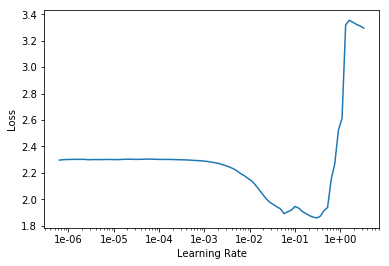

In [83]:
learner.lr_find()
learner.recorder.plot()

In [84]:
lr = slice(1e-2)
learner.fit_one_cycle(cyc_len=5, max_lr=lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.223979,0.216462,0.935700,00:09
1,0.207697,0.160787,0.954000,00:09
2,0.115794,0.134434,0.962400,00:09
3,0.075987,0.095291,0.974900,00:09
4,0.043663,0.087961,0.976000,00:09


In [88]:
%debug

> /usr/local/lib/python3.6/dist-packages/fastai/basic_train.py(395)show_results()
    393         #TODO: get read of has_arg x and split_kwargs_by_func if possible
    394         #TODO: simplify this and refactor with pred_batch(...reconstruct=True)
--> 395         n_items = rows ** 2 if self.data.train_ds.x._square_show_res else rows
    396         if self.dl(ds_type).batch_size < n_items: n_items = self.dl(ds_type).batch_size
    397         ds = self.dl(ds_type).dataset

ipdb> u
> <ipython-input-87-53ff49a39b78>(1)<module>()
----> 1 learner.show_results()

ipdb> print(k)
*** NameError: name 'k' is not defined
ipdb> q


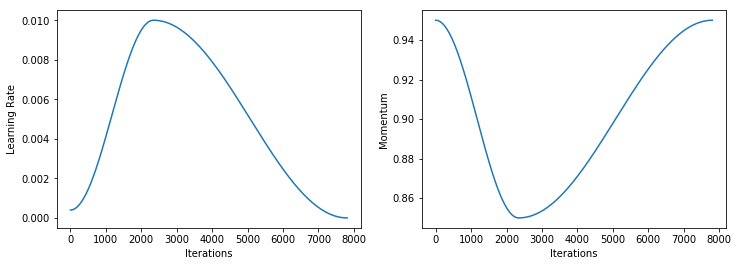

In [89]:
learner.recorder.plot_lr(show_moms=True)

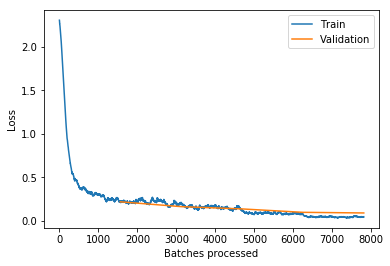

In [90]:
learner.recorder.plot_losses()